# Wink 2016 Analysis
@author: Max Felius

## Paper Reference:
Kim, J. W., Lu, Z., & Degrandpre, K. (2016). Ongoing deformation of sinkholes in Wink, Texas, observed by time-series Sentinel-1A SAR interferometry (preliminary results). Remote Sensing, 8(4), 313.

## Sinkhole parameters from the paper:
- Results from the MSBAS processing indicate that the vertical deformation is the most dominant component in ground deformation around Wink sinkholes, ~80% of LOS InSAR measurements.
- Displays a maximum subsidence of ~4cm in four months.
- Maximum subsidence at a rate of up to ~13cm/year.
- Deformation present already since 2009.
- extent of the subsidence area has increased. 

## Model Fit Parameters Used in Paper:
- Model: Okada, Y. (1985). Surface deformation due to shear and tensile faults in a half-space. Bulletin of the seismological society of America, 75(4), 1135-1154.
- Simple elastic displacement (cavity roof deflation), homogeneous elastic half space
- Source at 500 meter depth
- Two-source model; source one 120 x 10m and source two 80 x 10 meter

![](Wink2016.png)

## Analyse
- Apply inverse kinematic model using Gaussian Influence function and linear time. Estimate v(t) and R. Determine fit by using the following equation: $100 \cdot (1 - \frac{\sum |\hat{e}|}{\sum|y|})$.
- Test Different influence functions
- Test Mogi Model

### References
https://pubs.geoscienceworld.org/jeeg/article-abstract/17/2/75/139408 <br>
https://www.tandfonline.com/doi/full/10.1080/19475701003648077 <br>
https://pubs.geoscienceworld.org/ssa/bssa/article-abstract/75/4/1135/118782/Surface-deformation-due-to-shear-and-tensile?redirectedFrom=fulltext

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, time, os
import datetime
import re

In [2]:
#defining the different influence functions
def zg(R,r,itype='gaus'):
    '''
    Automatically uses the Gaussian Influence Function unless specified differently
    '''
    if itype == 'gaus':
        return -zg_gaus(R,r)
    elif itype == 'bals':
        return -zg_bals(R,r)
    elif itype == 'beyer':
        return -zg_beyer(R,r)
    else:
        print(f'Unknown itype: {itype}.')

def zg_gaus(R,r):
    return (1/(R*R))*np.exp(-np.pi*(r**2/R**2))

def zg_bals(H,r):
#     r = np.sqrt((x-x0)**2 + (y-y0)**2)
    zone = np.arctan(r/H)
    return np.cos(zone)**2

def zg_beyer(R,r):
#     r = np.sqrt((x-x0)**2 + (y-y0)**2)
    kz = ((3)/(np.pi*R**2))*(1-(r/R)**2)**2
    kz[r>R] = 0
    return kz

## Inverse Kinematic Model

Solve nonlinear Least Squares using the Gauss-Newton Method

In [3]:
#defining the inverse model
def inverse_kinematic_model(v,t,R,r,y,itype='gaus'):
    '''
    Non-Linear Least Squares for determining kinematic model parameters
    
    Input:
    :type v: int
    :type t: np.array(float)
    :type R: int
    :type r: np.array(float)
    :type y: np.array(float)
    
    Output
    :rtype R: int
    :rtype v: int
    '''
    #maximum number of runs
    n = 10000
    
    #initial values
    Qyy = np.eye(len(r))
    invQyy = np.linalg.inv(Qyy)
    
    #start the timer
    start = time.time()
    
    for i in range(n):
        #expected deformation
        yhat = v*t*zg(R,r,itype)
        
        #compute the difference in measured and computed subsidence
        dy = y - yhat
        
        #defining the jacobian matrix
        A1 = t*zg(R,r,itype)
        A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r,itype)
           
        J = np.array([A1,A2]).T
        
        Qxhat = np.linalg.inv(J.T @ invQyy @ J)
        dx = Qxhat @ J.T @ invQyy @ dy
        
        v_old = v
        R_old = R
        v = v + dx[0]
        R = R + dx[1]
        
        dx_hat = np.array([v_old-v,R_old-R]).T
        
        if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
            print(f'Stopped at iteration {i+1}.\nThe computed values are v={v} and R={R}.')
            break
    
    if i == n-1:
        print(f'Ended using the maximum number of iterations: {n}.\nThe computed values are v={v} and R={R}.')
    
    print(f'The total runtime was: {time.time()-start} seconds.')
    
    return v, R

## Linear Least Squares

In [4]:
def least_squares(t,R,r,y):
    '''
    Linear Least Squares
    '''
    #initial values
    Qyy = np.eye(len(r))
    invQyy = np.linalg.inv(Qyy)
    
    A = np.array([t*zg(R,r)]).T
    
    Qxhat = np.linalg.inv(A.T @ invQyy @ A)
    
    xhat = Qxhat @ A.T @ invQyy @ y
    
    return xhat

In [5]:
data_folder = 'Wink2016'

start_date = '20150421'
start_date_datetime = datetime.datetime.strptime(start_date,'%Y%m%d')
date_list = []
delta_days = []
data_list = []

for date in sorted(os.listdir(data_folder)):
    if date.endswith('.csv'):
        #get the date from the title
        m = re.search(r'\d{8}',date)
        date_conv = datetime.datetime.strptime(m.group(0),'%Y%m%d')
        date_list.append(date_conv)

        #Determine the number of days since the start date
        delta_days.append((date_conv-start_date_datetime).days)

        #Read the data from the files
        data_list.append(pd.read_csv(os.path.join(data_folder,date),header=None))

In [6]:
#extract and combine x and z coordinates and define t
x = np.array([])
y = np.array([])
t = np.array([])
nitems = 0
for idx,item in enumerate(data_list):
    nitems += 1
    n = len(item)
    t = np.concatenate((t,[delta_days[idx]]*n))
    x = np.concatenate((x,item[0].values))
    y = np.concatenate((y,item[1].values))

#from cm to meter
y = y/100
    
#define r
x0 = 480 #observed from the graph
r = np.sqrt((x-x0)**2)


In [7]:
#Gaussian Parameters
v_in = 1000
R_in = 470

gv, gR = inverse_kinematic_model(v_in,t,R_in,r,y)

Stopped at iteration 19.
The computed values are v=95.78920335026163 and R=553.0609564207195.
The total runtime was: 0.02889275550842285 seconds.


In [8]:
#Beyer Parameters
v_in = 1000
R_in = 470

beyer_v, beyer_R = inverse_kinematic_model(v_in,t,R_in,r,y,itype='beyer')

Stopped at iteration 30.
The computed values are v=77.41286350335778 and R=490.668750730957.
The total runtime was: 0.05551886558532715 seconds.


In [9]:
#Bals parameters
# extra assumption is made here. The limit angle gamma is set to 35 degrees
# gamma = np.deg2rad(23.5) #this gives an radius of influence of 480 m
gamma = np.deg2rad(35)

v_in = 1000
R_in = 480
H_in = R_in * np.tan(gamma)
# H_in = 500 #depth from the paper. Doesnt change the output of the model

bals_v, bals_H = inverse_kinematic_model(v_in,t,H_in,r,y,itype='bals')
print(f'R={bals_H/np.tan(gamma)} and H={bals_H}.')

Stopped at iteration 323.
The computed values are v=0.00034691933533114594 and R=208.91053812580117.
The total runtime was: 0.4993751049041748 seconds.
R=298.3551686117855 and H=208.91053812580117.


Gaussian Average Fit Percentage: 71.15%.
Beyer Average Fit Percentage: 67.76%.
Bals Average Fit Percentage: 72.91%.


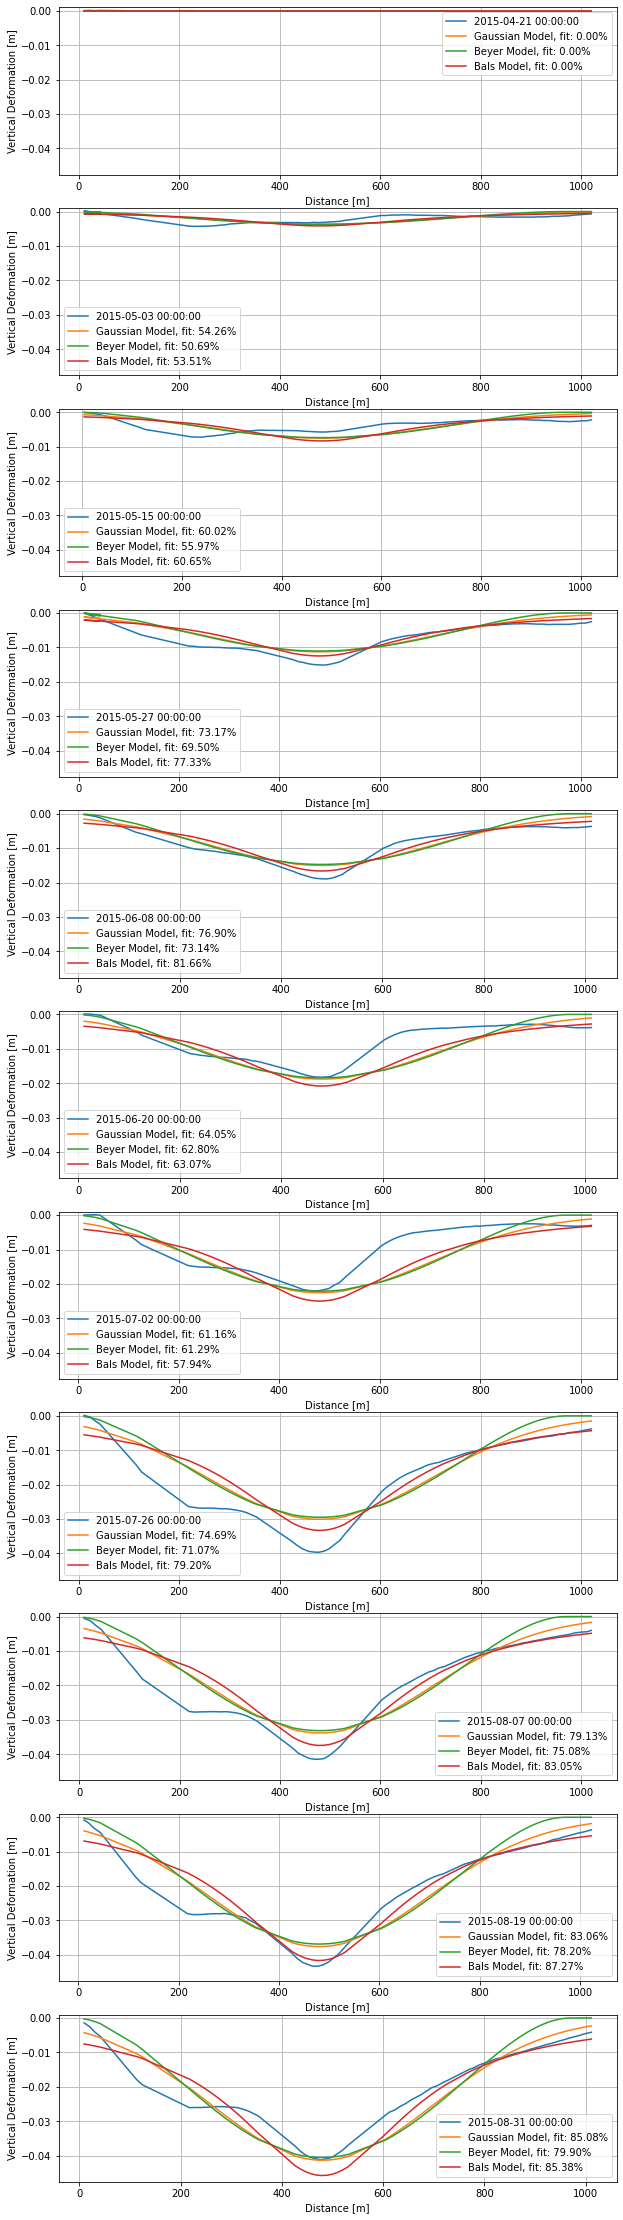

In [10]:
#plot the results

# plt.figure(figsize=(15,10))
fig, ax = plt.subplots(nrows=nitems, figsize = (10,40))
zmin = min(data_list[-2][1]/100)
fit_list = np.zeros((3,nitems))

for i in range(nitems):
    #compute some parameters
    y_data = data_list[i][1].values/100 #from cm to meter
    x1 = data_list[i][0].values
    r1 = np.sqrt((x1-x0)**2)
    
    #computing the gaussian model and fit
    y1 = gv*delta_days[i]*zg(gR,r1)
    ehat = y_data - y1
    gfit = 100*(1-(np.sum(abs(ehat))/np.sum(abs(y_data))))
    fit_list[0,i] = gfit
    
    #computing the beyer model and fit
    y2 = beyer_v*delta_days[i]*zg(beyer_R,r1,itype='beyer')
    ehat = y_data - y2
    beyer_fit = 100*(1-(np.sum(abs(ehat))/np.sum(abs(y_data))))
    fit_list[1,i] = beyer_fit
    
    #computing the bals model and fit
    y3 = bals_v*delta_days[i]*zg(bals_H,r1,itype='bals')
    ehat = y_data - y3
    bals_fit = 100*(1-(np.sum(abs(ehat))/np.sum(abs(y_data))))
    fit_list[2,i] = bals_fit
    
    #plotting the data
    ax[i].plot(x1,y_data,label=date_list[i])

    #plotting the gaussian model
    ax[i].plot(x1,y1,label='Gaussian Model, fit: {:.2f}%'.format(gfit))  
    
    #plotting the beyer model
    ax[i].plot(x1,y2,label='Beyer Model, fit: {:.2f}%'.format(beyer_fit))
    
    #plotting the beyer model
    ax[i].plot(x1,y3,label='Bals Model, fit: {:.2f}%'.format(bals_fit))
    
    #Notations
    ax[i].grid(True)
    ax[i].set_xlabel('Distance [m]')
    ax[i].set_ylabel('Vertical Deformation [m]')
    ax[i].set_ylim(zmin*1.1,0.001)
#     ax[i].set_title('Model fit: {:.4f}'.format(fit))
    ax[i].legend()

#skip the first fit percentage
print('Gaussian Average Fit Percentage: {:.2f}%.'.format(np.sum(fit_list[0,1:])/(nitems-1)))
print('Beyer Average Fit Percentage: {:.2f}%.'.format(np.sum(fit_list[1,1:])/(nitems-1)))                                                
print('Bals Average Fit Percentage: {:.2f}%.'.format(np.sum(fit_list[2,1:])/(nitems-1)))                                                


## Computed Parameters

Gaussian Influence Function:<br>
$R = 553 m$<br>
$v = 95.79 m^3/day$<br>
Gaussian Average Fit Percentage: 71.15%.

Beyer Influence Function:<br>
$R = 491m$<br>
$v = 77.41m^3/day$<br>
Beyer Average Fit Percentage: 67.76%.

Bals Influence Function: <br>
$R = 298m$ <br>
$H = 209m$ <br>
$\gamma = 35^o$ <br>
$v = 0.0003469 m^3/day$ <br> 
Bals Average Fit Percentage: 72.91%.

## Compare the Influence Functions with a Mogi Source

Assumptions
- Isotropic elastic half space (Poisson's ratio $\nu$; Shear modulus $\mu$)
- $\alpha$ << d (i.e. spherical point source)
- Incompressible magma

$$
\begin{pmatrix}
u \\
v \\
w
\end{pmatrix}
= \alpha^3 \Delta P \frac{(1-\nu)}{\mu}
\begin{pmatrix}
x/R^3 \\
y/R^3 \\
z/R^3
\end{pmatrix}
= \Delta V \frac{(1-\nu)}{\pi}
\begin{pmatrix}
x/R^3 \\
y/R^3 \\
z/R^3
\end{pmatrix}
$$
Where

$$R = \sqrt{(x-x_0)^2 + (y-y_0)^2 + (z-z_0)^2}$$
and $(x_0,y_0,z_0)$ is the postion of the cavity.

Source: http://indico.ictp.it/event/a08176/session/82/contribution/62/material/0/0.pdf <br>
Poissons' ratio ($\nu=0.3$) in Limburg (just an example): https://www.sciencedirect.com/science/article/abs/pii/S0013795202002065

Source of the subsidence is located at a depth of 500 meters. The only 'unknown' is the change in volume, $\Delta V$.

The Mogi model is adjusted slightly to incorporate a time element. 
$$
\begin{pmatrix}
u \\
v \\
w
\end{pmatrix}
= \Delta V_t t \frac{(1-\nu)}{\pi}
\begin{pmatrix}
x/R^3 \\
y/R^3 \\
z/R^3
\end{pmatrix}
$$

The physical data is a cross-section and thus the y-direction can be neglected. Also, the data only has vertical subsidence. The least-squares is applied to retrieve a parameter ($\Delta V_t$) only for the vertical deformation (w). 

In [11]:
def mogi(v,x,z,x0,z0):
    r = np.sqrt((x-x0)**2 + (z-z0)**2)
    return ((1-v)/np.pi) * np.array([(z-z0)/r**3])

In [12]:
def least_squares_mogi(t,v,x,z,x0,z0,y_measurements):
    '''
    Linear Least Squares
    '''
    #initial values
    Qyy = np.eye(len(x))
    invQyy = np.linalg.inv(Qyy)
    
    A = t * mogi(v,x,z,x0,z0)
    A = A.T #743x2
    
    Qxhat = np.linalg.inv(A.T @ invQyy @ A)
    
    xhat = Qxhat @ A.T @ invQyy @ y_measurements
    
    return xhat

In [13]:
poisson = 0.3

x = x #already defined
z = np.zeros((len(x))) 

x0 = 480
z0 = -500 #[m], from literature

xhat = least_squares_mogi(t,poisson,x,z,x0,z0,y)

print('Delta V is {:.2f} m3/day'.format(-xhat[0]))

Delta V is 287.98 m3/day


Mogi Average Fit Percentage: -4159.58%.


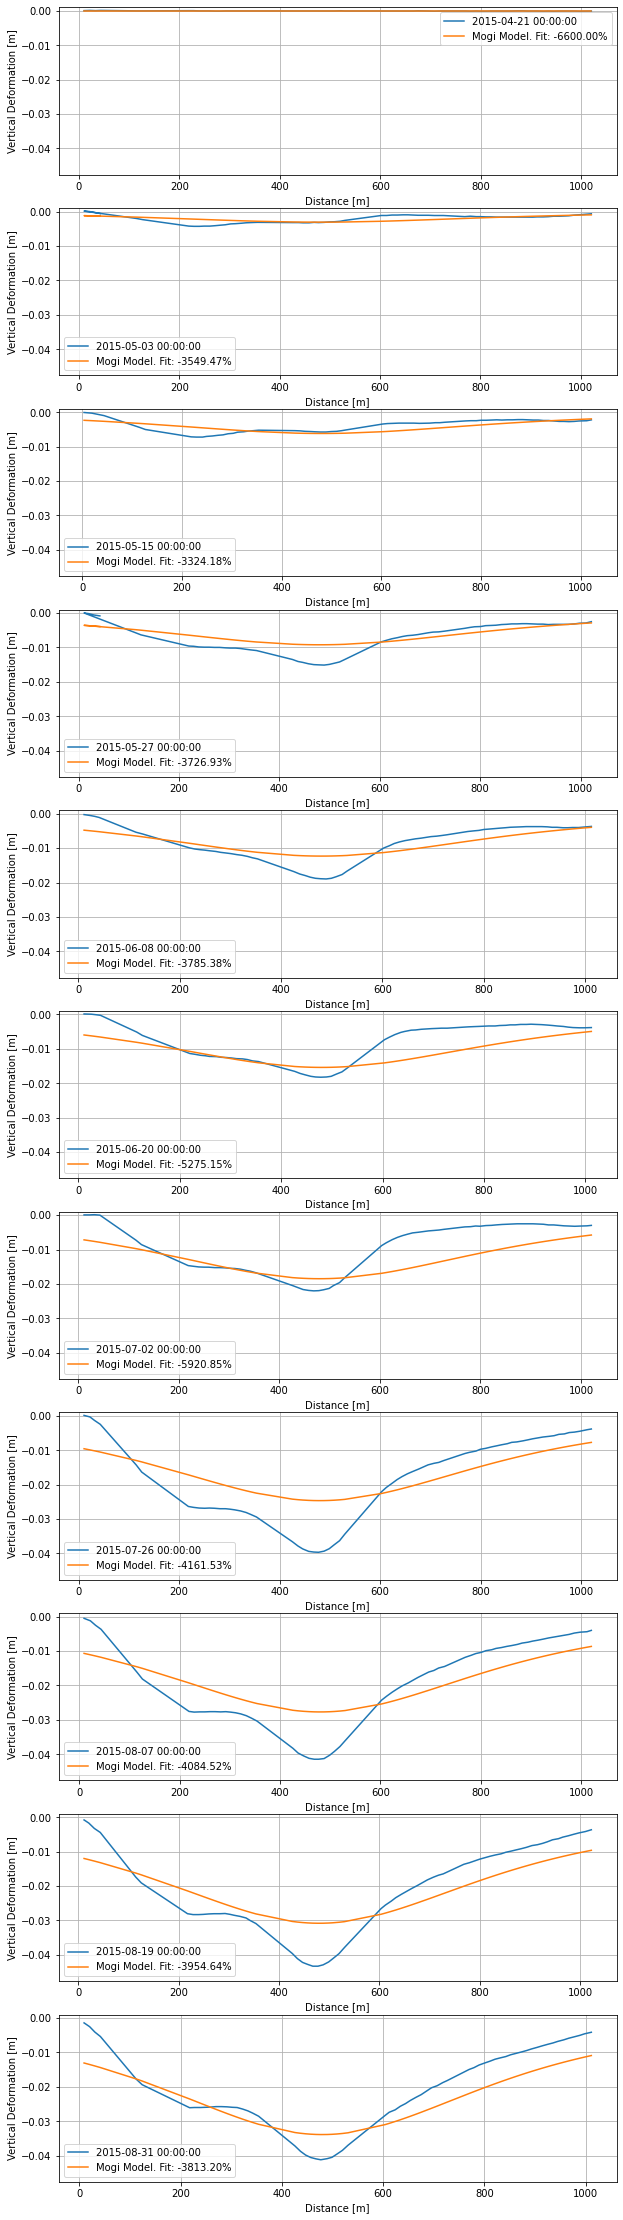

In [14]:
#plot the results

# plt.figure(figsize=(15,10))
fig, ax = plt.subplots(nrows=nitems, figsize = (10,40))
zmin = min(data_list[-2][1])/100
fit_list = np.zeros((1,nitems))

for i in range(nitems):
    #compute some parameters
    y_data = data_list[i][1].values/100 #from cm to meter
    x1 = data_list[i][0].values
    r1 = np.sqrt((x1-x0)**2)
    z1 = np.zeros((len(x1))) 
       
    #computing the fit
    y2 = xhat*delta_days[i]*mogi(poisson,x1,z1,x0,z0).T
    ehat = y_data - y2
    fit = 100*(1-(np.sum(abs(ehat))/np.sum(abs(y_data))))
    fit_list[0,i] = fit
    
    #plotting the data
    ax[i].plot(x1,y_data,label=date_list[i])

    #plotting the mogi model
    ax[i].plot(x1,xhat*delta_days[i]*mogi(poisson,x1,z1,x0,z0).T,label='Mogi Model. Fit: {:.2f}%'.format(fit))
    
    #Notations
    ax[i].grid(True)
    ax[i].set_xlabel('Distance [m]')
    ax[i].set_ylabel('Vertical Deformation [m]')
    ax[i].set_ylim(zmin*1.1,0.001)
#     ax[i].set_title('Model fit: {:.4f}'.format(fit))
    ax[i].legend()

#skip the first fit percentage
print('Mogi Average Fit Percentage: {:.2f}%.'.format(np.sum(fit_list[0,1:])/(nitems-1)))     

## Conclusions
- Looks like the Gaussian and the Bals functions have the best fit.
- The Radius of Influence and the Depth of the cavity look like it is not accurate.
- The Mogi model is not a good model for approximating sinkhole behavior